# Integrating scCAT-seq cell lines

## Imports

In [1]:
# Biology
import scanpy as sc
import muon as mu

In [18]:
# Our packages
from mowgli import models, pl, tl, utils

In [19]:
# Plotting
import matplotlib.pyplot as plt

## Load data

Load the Liu cell lines dataset, which contains 3 well separated cell lines profiled with scRNA-seq and scATAC-seq.

In [20]:
mdata = mu.read_h5mu('../datasets/liu_preprocessed.h5mu.gz')

For computational reasons, in this simple demonstration we reduce the number of features a lot.

In [21]:
sc.pp.highly_variable_genes(mdata['rna'], n_top_genes=500)
sc.pp.highly_variable_genes(mdata['atac'], n_top_genes=500)

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

In [22]:
# Umap RNA
sc.pp.scale(mdata['rna'], zero_center=False)
sc.tl.pca(mdata['rna'], svd_solver='arpack')
sc.pp.neighbors(mdata['rna'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['rna'], spread=1.5, min_dist=.5)

In [23]:
# Umap ATAC
sc.pp.scale(mdata['atac'], zero_center=False)
sc.tl.pca(mdata['atac'], svd_solver='arpack')
sc.pp.neighbors(mdata['atac'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['atac'], spread=1.5, min_dist=.5)

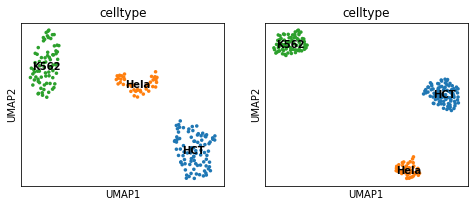

In [24]:
# Display UMAP
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.umap(mdata['rna'], color="celltype", legend_loc="on data", size=50, show=False, ax=axes[0])
sc.pl.umap(mdata['atac'], color="celltype", legend_loc="on data", size=50, show=False, ax=axes[1])
plt.show()

## Train model

Let us define the model and perform the dimensionaly reduction.

In [25]:
# Define the model.
nmf = models.MowgliModel(
    latent_dim=3,
    rho_h=1e-2,
    rho_w=1e-3,
    eps=.1,
    cost='cosine')

In [26]:
# Perform the training.
nmf.train(mdata)

  3%|▎         | 6/200 [00:30<16:25,  5.08s/it, loss=-0.29857898, mass_transported=0.833, loss_inner=0.29244643, inner_steps=130, gpu_memory_allocated=0]


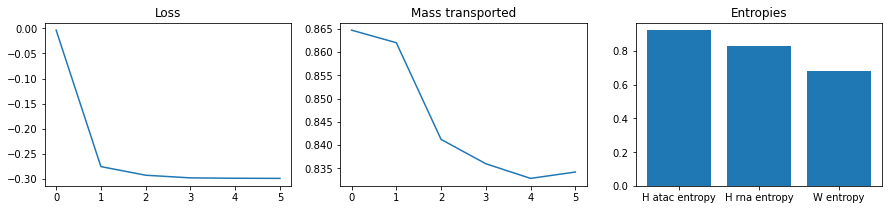

In [34]:
# Display the training statistics.
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].set_title('Loss')
axes[0].plot(nmf.losses)

axes[1].set_title('Mass transported')
axes[1].plot(nmf.scores_history[1:])

entropies, labels = [], []
for mod in nmf.mod:
    entropies.append(utils.entropy(nmf.H[mod], rescale=True))
    labels.append(' '.join(['H', mod, 'entropy']))
entropies.append(utils.entropy(nmf.W, rescale=True))
labels.append('W entropy')
axes[2].set_title('Entropies')
axes[2].bar(labels, entropies)

plt.show()

## Visualize the embedding

Now, let us display the obtained embedding.

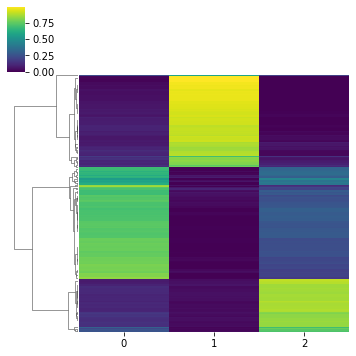

In [14]:
# First, using a dendogram.
pl.clustermap(mdata, 'W_OT', yticklabels=False, figsize=(5, 5), col_cluster=False)

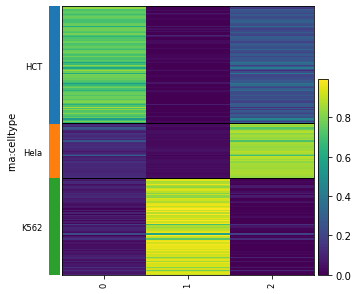

In [15]:
# Then, using the ground truth clusters.
pl.heatmap(mdata, 'W_OT', 'rna:celltype', figsize=(5, 5))

In [37]:
# Finally, we can compute an UMAP embedding.
tl.umap(mdata, 'W_OT')

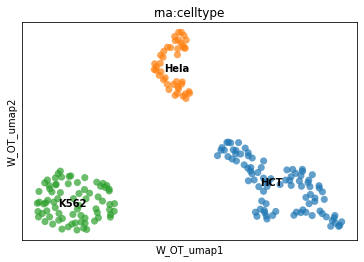

In [44]:
# And display it...
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=200, alpha=.7, legend_loc='on data')

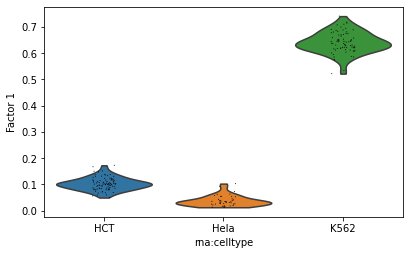

In [54]:
# Display a violin plot of the value at a given dimension of the cells.
pl.factor_violin(mdata, groupby='rna:celltype', dim=1)

## Clustering

We can perform clustering on the lower-dimensional space.

In [57]:
tl.leiden(mdata, resolution=.1)

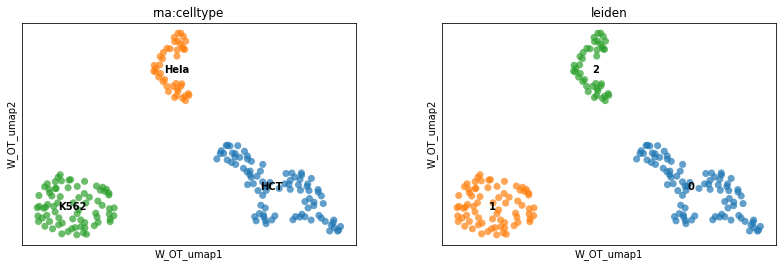

In [58]:
mu.pl.embedding(mdata, 'W_OT_umap', ['rna:celltype', 'leiden'], size=200, alpha=.7, legend_loc='on data')